<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Sebastián Bustos Vásquez</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [2]:
import gzip

# Ruta del archivo
archivo = 'L-L1_GWOSC_16KHZ_R1-1242459842-32.txt.gz'

# Abrir archivo gz en modo texto (rt, ya que también se puede abrir para que entregue la info como binario)
with gzip.open(archivo, 'rt') as f:
    for i, linea in enumerate(f):
        print(linea.strip())    # .strip() elimina los saltos de linea al final
        if i == 9:              # i comienza en 0
            break               

# Gravitational wave strain for GW190521_074359-v2 for L1 (see http://losc.ligo.org)
# This file has 16384 samples per second
# starting GPS 1242459842 duration 32
-9.5849557622070306e-21
1.6255500067458557e-22
-9.0475530680193115e-21
-6.5347458102234209e-21
1.7078631995663690e-21
-1.4959073827611127e-20
2.8405217853073312e-22


El archivo cargado menciona que se utilizó un muestreo de 16.384 muestras por segundos, y duración de 32 segundos

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [3]:
import numpy as np
from scipy.io.wavfile import write

# Frecuencia de muestreo
fs = 16384

datos = [] # lista donde se almacenaran los datos del archivo L-L1_GWOSC_16KHZ_R1-1242459842-32.txt
with gzip.open(archivo, 'rt') as f: 
    for linea in f:
        if linea.startswith('#'):  # dejar de lado lineas de comentario
            continue
        datos.append(float(linea.strip()))  #.append agrega los datos (convertido a flotante) a la lista datos


datos_np = np.array(datos, dtype=np.float32) # Convertir la lista a un array de NumPy, y los datos a flotante de 32 bits

# Escalar los datos para el formato de audio (16-bit)
# Esto es necesario porque los datos gravitacionales estan en un rango muy pequeno
scaled = np.int16(datos_np / np.max(np.abs(datos_np)) * 32767)

# Escribir los datos en formato WAV
write('livingstone_audio.wav', fs, scaled)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


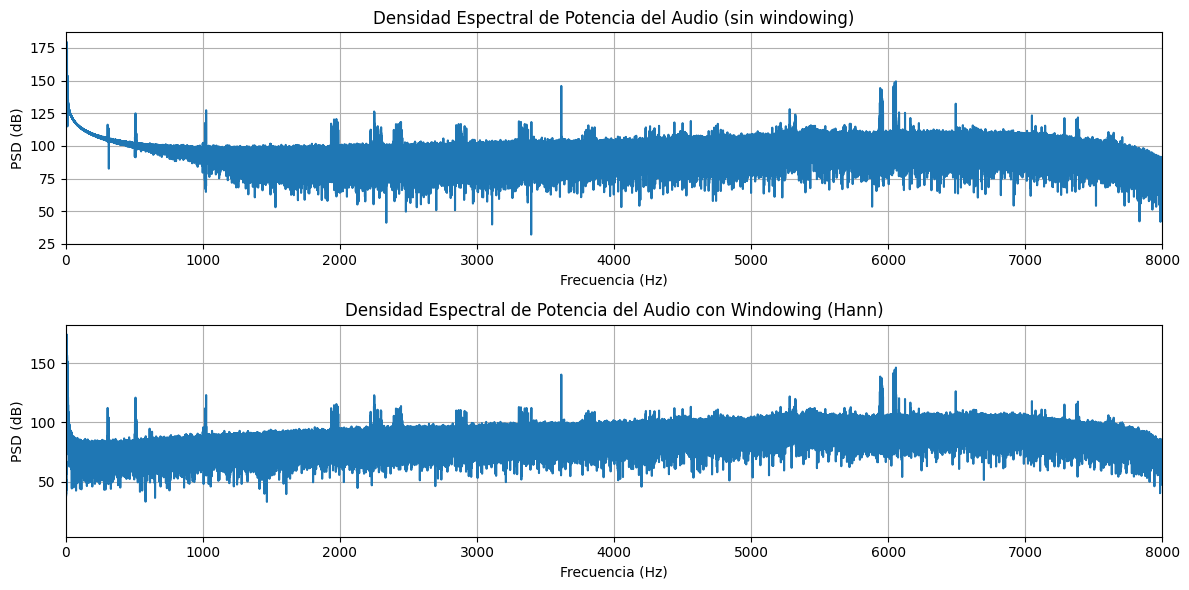

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import get_window

# Leer archivo de audio
fs, data = wavfile.read('livingstone_audio.wav')

# Asegurarse de que 'data' es un array de una sola dimension (monocanal)
if data.ndim > 1:
    data = data[:, 0]  # Tomar solo el primer canal
    print("El array tenía más de una dimensión. Se ha seleccionado el primer canal.")

# Aplicar windowing usando la ventana de Hann
window = get_window('hann', len(data))
data_window = data * window

# Calcular FFT del audio, sin windowing
fft_resultado = fft(data)
n = len(fft_resultado)  # Numero de puntos en la FFT
freq = fftfreq(n, 1/fs)
# Calcular FFT del audio con windowing
fft_resultado_window = fft(data_window)
n_window = len(fft_resultado_window)
freq_window = fftfreq(n, 1/fs)
 
# Calcular PSD
# Sin windowing
fft_magnitud = np.abs(fft_resultado)
fft_magnitud_db = 20 * np.log10(fft_magnitud)
# Con windowing
fft_magnitud_window = np.abs(fft_resultado_window)
fft_magnitud_db_window = 20 * np.log10(fft_magnitud_window)

# Limitar a frecuencias positivas
positive_freq = freq > 0
freq = freq[positive_freq]
freq_window = freq_window[positive_freq]

fft_magnitud_db = fft_magnitud_db[positive_freq]
fft_magnitud_db_window = fft_magnitud_db_window[positive_freq]

# Graficar la densidad espectral de potencia
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq, fft_magnitud_db)
plt.title('Densidad Espectral de Potencia del Audio (sin windowing)')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 8000)  
plt.ylabel('PSD (dB)')
plt.grid(True)

plt.subplot(2, 1 ,2)
plt.plot(freq_window, fft_magnitud_db_window)
plt.title('Densidad Espectral de Potencia del Audio con Windowing (Hann)')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 8000)  
plt.ylabel('PSD (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()


Se observan varias componentes de frecuencia de las que podemos confundirnos pensando que es la señal gravitatoria al tener bastante energía.

La ventana de Hann modifica la señal multiplicándola por una función que tiene un valor de cero en ambos extremos y uno en el centro. Esta ventana suaviza los extremos de la señal, lo que puede introducir cierta cantidad de energía a frecuencias bajas que no son tan dominantes en la señal original, pero puede mejorar la precisión de la representación espectral al minimizar los efectos de discontinuidad.

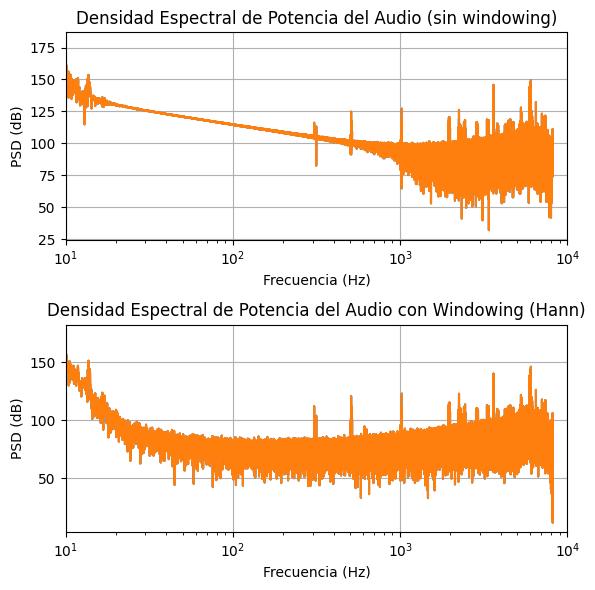

In [5]:
# Grafica de densidad espectral de potencia (EJE X en escala Logaritmica)
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(freq, fft_magnitud_db)
plt.semilogx(freq, fft_magnitud_db)
plt.title('Densidad Espectral de Potencia del Audio (sin windowing)')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(10, 10000)  
plt.ylabel('PSD (dB)')
plt.grid(True)

plt.subplot(2, 1 ,2)
plt.plot(freq_window, fft_magnitud_db_window)
plt.title('Densidad Espectral de Potencia del Audio con Windowing (Hann)')
plt.xlabel('Frecuencia (Hz)')
plt.semilogx(freq_window, fft_magnitud_db_window)
plt.xlim(10, 10000)  
plt.ylabel('PSD (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()

Misma gráfica pero el eje X de frecuencias se transformó para representarla logarítmicamente.

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


C:\Users\sebas\AppData\Local\Temp\ipykernel_22260\2906453013.py:16: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  window = tukey(len(data), alpha=0.5)


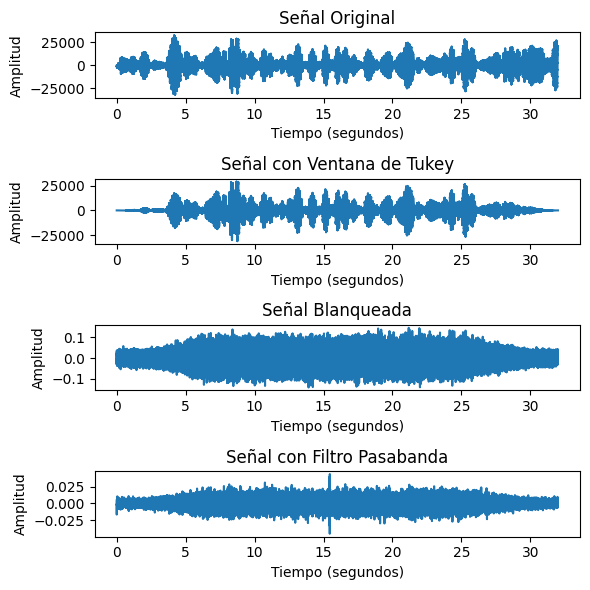

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import tukey, butter, filtfilt
from scipy.fft import fft, ifft

# Cargar datos
fs, data = wavfile.read('livingstone_audio.wav')
if data.ndim > 1:
    data = data[:, 0]  # Tomar solo el primer canal

# Calcular tiempo para cada muestra
t = np.arange(len(data)) / fs

# Aplicar ventana de Tukey
window = tukey(len(data), alpha=0.5)
data_window = data * window

# FFT para convertir a dominio de frecuencia
fft_data = fft(data_window)

# Estimacion de la densidad espectral de ruido 
ruido_espectral = np.abs(fft_data) / 20  

# Whitening o Blanqueado
blanqueado_fft_data = fft_data / (ruido_espectral + 1e-6)  # Evitar division por cero

#  IFFT para volver al dominio del tiempo despues del blanqueado
blanqueado_ifft = ifft(blanqueado_fft_data).real

# Filtrado pasa banda entre 35 y 500 Hz
b, a = butter(4, [35/(fs/2), 500/(fs/2)], btype='band')
filtropb_data = filtfilt(b, a, blanqueado_ifft)

# Grafica con el tiempo en eje x
plt.figure(figsize=(6, 6))
plt.subplot(4, 1, 1)
plt.plot(t, data,)
plt.title('Señal Original')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')


plt.subplot(4, 1, 2)
plt.plot(t, data_window,)
plt.title('Señal con Ventana de Tukey')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')


plt.subplot(4, 1, 3)
plt.plot(t, blanqueado_ifft,)
plt.title('Señal Blanqueada')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')

plt.subplot(4, 1, 4)
plt.plot(t, filtropb_data,)
plt.title('Señal con Filtro Pasabanda')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

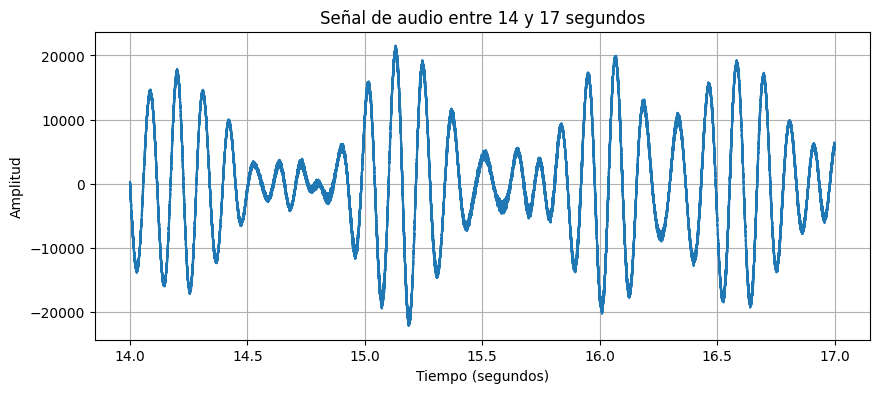

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Cargar datos de audio
fs, data = wavfile.read('livingstone_audio.wav')

# Definir intervalo de tiempo a analizar (en segundos)
start_time = 14  
end_time = 17 
start_index = int(start_time * fs)
end_index = int(end_time * fs)
selected_data = data[start_index:end_index]

# Grafica de datos 
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(start_time, end_time, len(selected_data)), selected_data)
plt.title('Señal de audio entre 14 y 17 segundos')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()


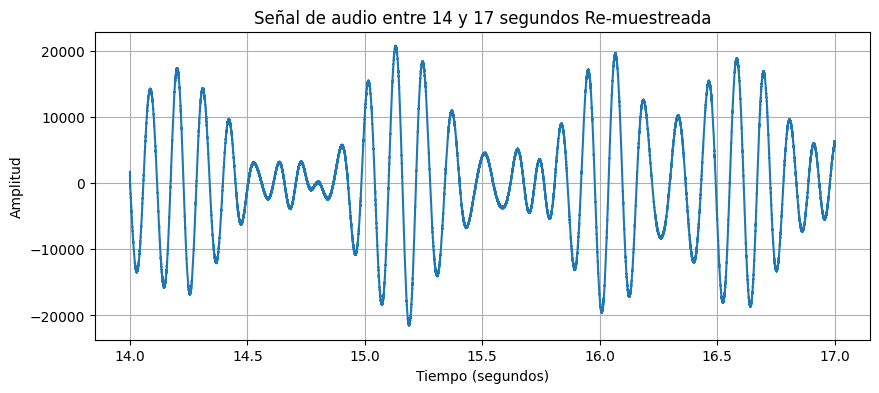

In [8]:
from scipy.signal import resample
from scipy.io import wavfile

# Definir nueva frecuencia de muestreo
nueva_fs = 8192 

# Calcular numero de muestras para la nueva tasa
num_samples = int(len(selected_data) * (nueva_fs / fs))

# Re-muestrear los datos
data_remuestrada = resample(selected_data, num_samples)

# Grafica de datos re-muestreados
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(start_time, end_time, num_samples), data_remuestrada)
plt.title('Señal de audio entre 14 y 17 segundos Re-muestreada')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()


# resampled_data y 'new_fs' son tus datos y frecuencia de muestreo resampleados
wavfile.write('remuestrada_livingstone.wav', nueva_fs, data_remuestrada.astype(np.int16))



Señal de audio resampleada tomando en cuenta el pico de amplitud presente entre los segundos 15 y 18 aproximadamente, por lo que se cortó el audio para analizar sólo 3 segundos de toda la señal y es donde se encuentra presente el pico.

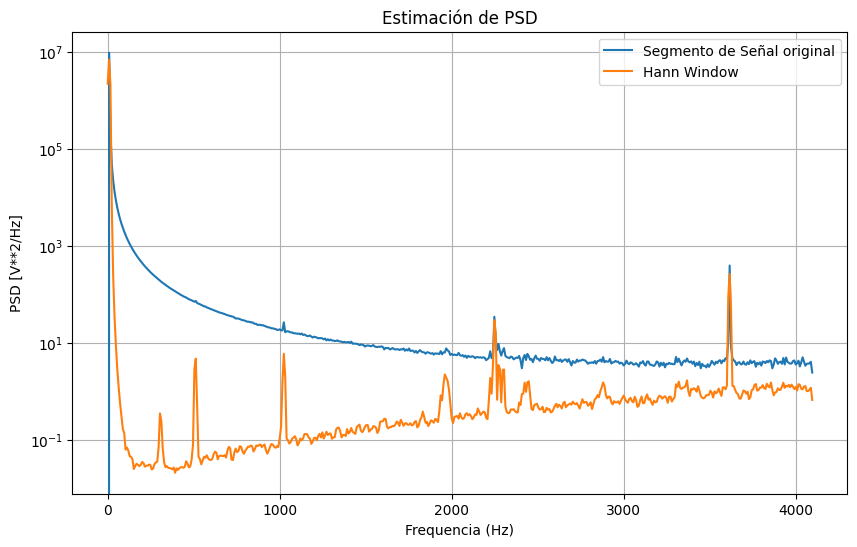

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch, hann

# Cargar datos de audio resampleados
fs, data = wavfile.read('remuestrada_livingstone.wav')

# Estimar PSD sin windowing
frequencia_no_window, psd_no_window = welch(data, fs=fs, window='boxcar', nperseg=1024, scaling='density')

# Estimar PSD con windowing Hann
frequencia_hann, psd_hann = welch(data, fs=fs, window='hann', nperseg=1024, scaling='density')

# Visualización
plt.figure(figsize=(10, 6))
plt.semilogy(frequencia_no_window, psd_no_window, label='Segmento de Señal original')
plt.semilogy(frequencia_hann, psd_hann, label='Hann Window')
plt.title('Estimación de PSD')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sebas\AppData\Local\Temp\ipykernel_22260\157583543.py:16: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  window = tukey(len(data), alpha=0.5)


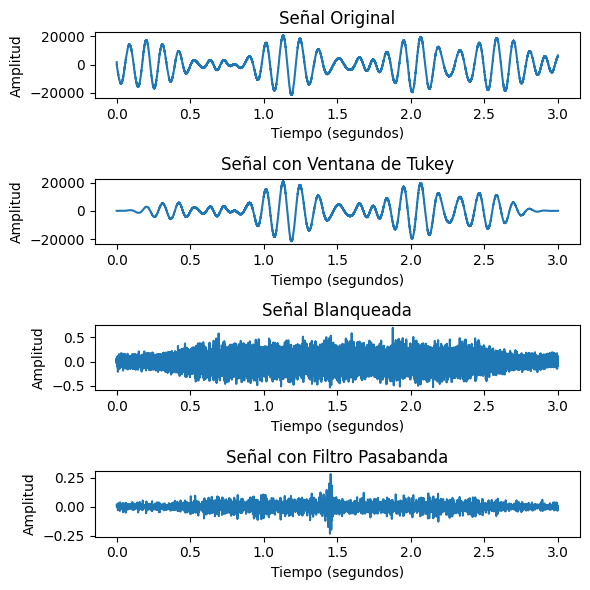

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import tukey, butter, filtfilt
from scipy.fft import fft, ifft

# Cargar datos
fs, data = wavfile.read('remuestrada_livingstone.wav') 
if data.ndim > 1:
    data = data[:, 0]  # Tomar solo el primer canal

# Calcular tiempo para cada muestra
t = np.arange(len(data)) / fs

# Aplicar Tukey window
window = tukey(len(data), alpha=0.5)
data_window = data * window

# FFT para convertir a dominio de frecuencia
fft_data = fft(data_window)

# Estimación de la densidad espectral de ruido (simulada en este caso)
ruido_espectral = np.abs(fft_data) / 20  # Este es un ejemplo simple, debería basarse en datos reales de ruido

# Whitening
blanqueado_fft_data = fft_data / (ruido_espectral + 1e-6)  # Evitar división por cero

# Inversa FFT para volver al dominio del tiempo después del whitening
blanqueado_ifft = ifft(blanqueado_fft_data).real

# Filtrado pasa banda
b, a = butter(4, [35/(fs/2), 350/(fs/2)], btype='band')
filtropb_data = filtfilt(b, a, blanqueado_ifft)

# Grafica con el tiempo en eje x
plt.figure(figsize=(6, 6))
plt.subplot(4, 1, 1)
plt.plot(t, data,)
plt.title('Señal Original')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')


plt.subplot(4, 1, 2)
plt.plot(t, data_window,)
plt.title('Señal con Ventana de Tukey')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')


plt.subplot(4, 1, 3)
plt.plot(t, blanqueado_ifft,)
plt.title('Señal Blanqueada')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')

plt.subplot(4, 1, 4)
plt.plot(t, filtropb_data,)
plt.title('Señal con Filtro Pasabanda')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()


Mismo procedimiento que se hizo con la señal completa

In [11]:
import numpy as np
from scipy.io import wavfile

# Suponiendo que blanqueado_ifft es tu array de datos blanqueados
# Normaliza los datos blanqueados
max_int16 = 32767
scaled_data = np.int16(blanqueado_ifft / np.max(np.abs(blanqueado_ifft)) * max_int16)

# Escribir el archivo WAV
wavfile.write('blanqueado_L_audio.wav', fs, scaled_data)


Generar audio de la señal blanqueada para aplicar un escalograma y visualizar el pico de amplitud encontrado anteriormente

Segmento de longitud: 24576 muestras


C:\Users\sebas\AppData\Local\Temp\ipykernel_22260\4197391829.py:25: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = cwt(segment, ricker, widths)


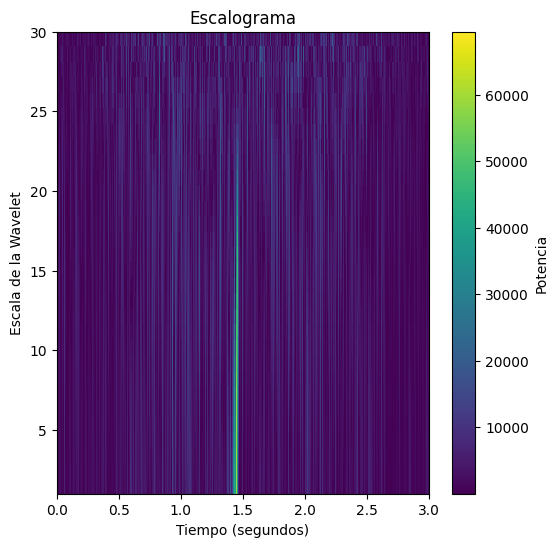

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import cwt, ricker

# Cargar archivo de audio blanqueado
fs, data = wavfile.read('blanqueado_L_audio.wav')

# Seleccionar todo el segmento
start_sec = 0
end_sec = 3
start_index = int(start_sec * fs)
end_index = int(end_sec * fs)
segment = data[start_index:end_index]

if len(segment) == 0:
    print("El segmento está vacío. Asegúrate de que los índices son correctos.")
else:
    print(f"Segmento de longitud: {len(segment)} muestras")

# Configurar parametros para transformada wavelet continua
widths = np.arange(1, 31)  # Usar menos escalas y asegurarse de que sean adecuadas para el tamaño del segmento

# Calcular la CWT usando una wavelet Ricker para simplicidad
cwtmatr = cwt(segment, ricker, widths)

# Graficar el escalograma
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(cwtmatr), extent=[0, len(segment) / fs, 1, len(widths)], aspect='auto',
           interpolation='nearest', cmap='viridis')
plt.colorbar(label='Potencia')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Escala de la Wavelet')
plt.title('Escalograma')
plt.show()


